In [1]:
"""
Gaussian HMM of stock data
--------------------------

This script shows how to use Gaussian HMM on stock price data from
Google finance.
"""

from __future__ import print_function

import datetime

import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from quotes_api import quotes_historical_google
from hmmlearn.hmm import GaussianHMM

In [2]:
"""
print(__doc__)
from urllib.request import urlopen
html = urlopen("http://www.google.com/")
print(html)
"""
# Get quotes from Google finance
"""
quotes = quotes_historical_google(
"GOOG", datetime.date(2010, 1, 1), datetime.date(2012, 1, 6))

print(quotes)

"""
"""
import pandas as pd
df=pd.read_csv('AAPL5y.csv', sep=',')
print(df)
"""

"\nimport pandas as pd\ndf=pd.read_csv('AAPL5y.csv', sep=',')\nprint(df)\n"

In [3]:
from numpy import genfromtxt
from datetime import datetime

data_type={
    'names': ['date', 'close', 'volume', 'open', 'high', 'low'],
    'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
}

converters = {0: lambda x: datetime.strptime(x.decode(), '%Y/%m/%d')}
quotes = genfromtxt('./AAPL5y.csv', delimiter=',', skip_header=1, dtype=data_type, converters=converters, missing_values='-', filling_values=-1)
quotes = quotes[1:-1]
print(quotes)

[ (datetime.datetime(2018, 1, 12, 0, 0),  177.08999634,   2.53022000e+07,  176.17999268,  177.36000061,  175.6499939 )
 (datetime.datetime(2018, 1, 11, 0, 0),  175.27999878,   1.86533800e+07,  174.58999634,  175.48860168,  174.49000549)
 (datetime.datetime(2018, 1, 10, 0, 0),  174.28999329,   2.37516900e+07,  173.16000366,  174.30000305,  173.        )
 ...,
 (datetime.datetime(2013, 1, 17, 0, 0),   71.81140137,   1.12900448e+08,   72.90139771,   72.96430206,   71.71849823)
 (datetime.datetime(2013, 1, 16, 0, 0),   72.29850006,   1.72393952e+08,   70.66280365,   72.77709961,   70.35710144)
 (datetime.datetime(2013, 1, 15, 0, 0),   69.417099  ,   2.17802608e+08,   71.18569946,   71.28430176,   69.0542984 )]


In [4]:
# Unpack quotes
dates = np.array([int(q[0].strftime("%s")) for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]

In [5]:
# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

# Pack diff and volume for training.
X = np.column_stack([diff, volume])

In [6]:
###############################################################################
# Run Gaussian HMM
print("fitting to HMM and decoding ...", end="")

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("done")

###############################################################################

fitting to HMM and decoding ...done


/home/lunarpulse/miniconda3/envs/cryptocurrency/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/lunarpulse/miniconda3/envs/cryptocurrency/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/lunarpulse/miniconda3/envs/cryptocurrency/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, cat

In [7]:
# Print trained parameters and plot
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

Transition matrix
[[  9.94259772e-001   5.74022836e-003   2.24769718e-130   1.24440626e-263]
 [  1.76198045e-003   9.96485321e-001   1.75269848e-003   2.71305703e-125]
 [  3.07132338e-243   1.14840757e-113   9.89302349e-001   1.06976513e-002]
 [  5.77028441e-197   7.07843959e-080   1.33922919e-002   9.86607708e-001]]

Means and vars of each hidden state
0th hidden state
mean =  [-48054.13131462    144.47625705]
var =  [  1.61809253e+14   2.53680632e+02]

1th hidden state
mean =  [ 93207.84136337    105.59911823]
var =  [  3.84068680e+14   8.00631108e+01]

2th hidden state
mean =  [  1.24489546e+05   7.52310714e+01]
var =  [  1.00492986e+15   1.72972369e+01]

3th hidden state
mean =  [  8.87023287e+05   6.23168639e+01]
var =  [  1.75753162e+15   8.54164967e+00]



In [8]:
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

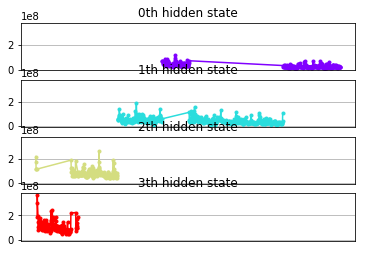

In [9]:
plt.show()